In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [4]:
adjusted_close = pd.read_csv('data/adj_close.csv', index_col=0, parse_dates=True)

In [5]:
price_series = adjusted_close['JPM'].dropna()
price_series

Date
2015-06-24     52.450134
2015-06-25     52.168957
2015-06-26     52.396927
2015-06-29     51.067074
2015-06-30     51.492626
                 ...    
2025-06-13    264.950012
2025-06-16    270.359985
2025-06-17    269.519989
2025-06-18    273.959991
2025-06-20    275.000000
Name: JPM, Length: 2513, dtype: float64

In [67]:
# feature creation

lags = 5
windows = [5, 10, 20, 50]

dataset = pd.DataFrame(index=price_series.index) # just dates df

for lag in range(1, lags+1):
    # past returns over lag days
    dataset[f'return_over_{lag}_days'] = price_series.pct_change(lag) 

for window in windows:
    # moving average over last [window] days
    dataset[f'mov_avg_{window}_days'] = price_series.rolling(window).mean()
    # ratio of price to this moving average
    dataset[f'mov_avg_ratio_{window}_days'] = price_series / dataset[f'mov_avg_{window}_days']

for window in windows:
    # daily returns volatility over window days
    dataset[f'vol_over_{window}_days'] = price_series.pct_change().rolling(window).std()

# Relative Strength Index
for window in windows:
    delta = price_series.diff()
    gain = delta.where(delta > 0, 0)
    avg_gain = gain.rolling(window).mean()
    loss = delta.where(delta < 0, 0)
    avg_loss = loss.rolling(window).mean()
    # relative strengh
    rs = avg_gain / avg_loss
    dataset[f'rsi_{window}_days'] = 100 - (100 / (1 + rs))

dataset.dropna(inplace=True)

# target creation

# shift pct changes and check if positive (1) or negative (0)
dataset['target'] = (price_series.pct_change().shift(-1) > 0).astype(int)

dataset.dropna(inplace=True) # features and targets have separate Nan values so combine and drop

In [71]:
# rsi calculation can lead to divide by zero
inf_counts = np.isinf(dataset).sum()
print("Infinite values per column:")
print(inf_counts[inf_counts > 0])  # Only show columns with infinities (dropped in next cell)

Infinite values per column:
Series([], dtype: int64)


In [70]:
dataset = dataset.replace([np.inf, -np.inf], np.nan).dropna()

In [80]:
X = dataset.drop(columns=['target'])
y = dataset['target']

time_series_cv = TimeSeriesSplit(n_splits=5)

for train_index, test_index in time_series_cv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [79]:
scaler = RobustScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test) # used fit on accident earlier

models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(n_estimators=100, random_state=42),
    'LightGBM':  LGBMClassifier(n_estimators=100, random_state=42)
}

results = {}
for name, model in models.items():
    model.fit(X_train_s, y_train)
    y_pred = model.predict(X_test_s)
    #  # https://stackoverflow.com/questions/30056331/how-to-list-all-scikit-learn-classifiers-that-support-predict-proba
    # some models don't have predict_proba - ignored for now
    y_proba = model.predict_proba(X_test_s)[:, 1]

    results[name] = {
        'model': model,
        'accuracy': accuracy_score(y_test, y_pred),
        'classification_report': classification_report(y_test, y_pred),
        'confusion_matrix': confusion_matrix(y_test, y_pred),
        'predictions': y_pred,
        'probabilities': y_proba
    }

    print(f"{name} Accuracy: {results[name]['accuracy']:.2f}")
    print(classification_report(y_test, y_pred))

Random Forest Accuracy: 0.43
              precision    recall  f1-score   support

           0       0.42      1.00      0.59       168
           1       1.00      0.03      0.06       241

    accuracy                           0.43       409
   macro avg       0.71      0.51      0.32       409
weighted avg       0.76      0.43      0.28       409

XGBoost Accuracy: 0.42
              precision    recall  f1-score   support

           0       0.40      0.83      0.54       168
           1       0.53      0.13      0.21       241

    accuracy                           0.42       409
   macro avg       0.47      0.48      0.38       409
weighted avg       0.48      0.42      0.35       409

[LightGBM] [Info] Number of positive: 1038, number of negative: 1012
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000307 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of d

/Users/achintyajha/miniconda3/envs/ml/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/achintyajha/miniconda3/envs/ml/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [84]:
# scaler = RobustScaler()
# X_train_s = scaler.fit_transform(X_train)
# X_test_s = scaler.transform(X_test) # used fit on accident earlier
X_train_s = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_s = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
    'XGBoost': XGBClassifier(n_estimators=100, random_state=42, scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1])),
    'LightGBM':  LGBMClassifier(n_estimators=100, random_state=42, is_unbalance=True)
}

results = {}
for name, model in models.items():
    model.fit(X_train_s, y_train)
    y_pred = model.predict(X_test_s)
    #  https://stackoverflow.com/questions/30056331/how-to-list-all-scikit-learn-classifiers-that-support-predict-proba
    # some models don't have predict_proba - ignored for now
    y_proba = model.predict_proba(X_test_s)[:, 1]

    results[name] = {
        'model': model,
        'accuracy': accuracy_score(y_test, y_pred),
        'classification_report': classification_report(y_test, y_pred),
        'confusion_matrix': confusion_matrix(y_test, y_pred),
        'predictions': y_pred,
        'probabilities': y_proba
    }

    results[name]['roc_auc'] = roc_auc_score(y_test, y_proba)
    print(f"{name} ROC-AUC: {results[name]['roc_auc']:.2f}")
    print(f"{name} Accuracy: {results[name]['accuracy']:.2f}")
    print(classification_report(y_test, y_pred))

Random Forest ROC-AUC: 0.50
Random Forest Accuracy: 0.42
              precision    recall  f1-score   support

           0       0.41      0.96      0.58       168
           1       0.63      0.05      0.09       241

    accuracy                           0.42       409
   macro avg       0.52      0.50      0.33       409
weighted avg       0.54      0.42      0.29       409

XGBoost ROC-AUC: 0.51
XGBoost Accuracy: 0.43
              precision    recall  f1-score   support

           0       0.41      0.83      0.55       168
           1       0.57      0.16      0.25       241

    accuracy                           0.43       409
   macro avg       0.49      0.49      0.40       409
weighted avg       0.50      0.43      0.37       409

[LightGBM] [Info] Number of positive: 1038, number of negative: 1012
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000393 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [I

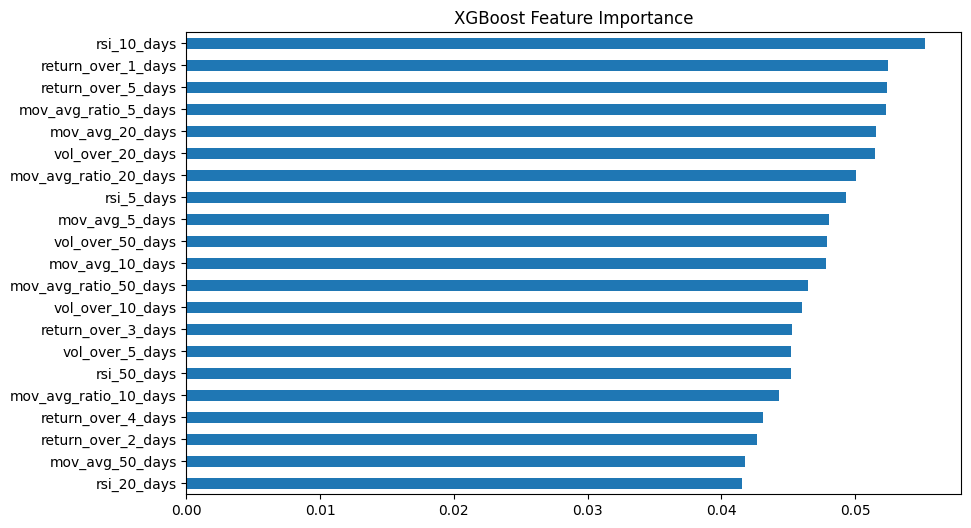

In [88]:
# Plot feature importance
importances = pd.Series(best_xgb.feature_importances_, index=X_train.columns)
importances.sort_values().plot.barh(figsize=(10, 6))
plt.title("XGBoost Feature Importance")
plt.show()

## really poor results as of now